In [1]:
import numpy as np
import h5py
import os

In [2]:
path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/datasets/Patch Camelyon/Data/'

In [3]:
x_1 = h5py.File(path + 'camelyonpatch_level_2_split_test_x.h5', 'r')
y_1 = h5py.File(path + 'camelyonpatch_level_2_split_test_y.h5', 'r')
x_2 = h5py.File(path + 'camelyonpatch_level_2_split_valid_x.h5', 'r')
y_2 = h5py.File(path + 'camelyonpatch_level_2_split_valid_y.h5', 'r')

In [4]:
data_x1 = np.array(x_1['x'][:])
data_y1 = np.array(y_1['y'][:])

In [5]:
data_x2 = np.array(x_2['x'][:])
data_y2 = np.array(y_2['y'][:])

In [6]:
data_x1.shape, data_y1.shape, data_x2.shape, data_y2.shape

((32768, 96, 96, 3), (32768, 1, 1, 1), (32768, 96, 96, 3), (32768, 1, 1, 1))

In [7]:
final_data_x = np.concatenate((data_x1, data_x2), axis=0)
final_data_y = np.concatenate((data_y1, data_y2), axis=0)
final_data_y = final_data_y.reshape((final_data_y.shape[0], ))

In [8]:
final_data_x.shape, final_data_y.shape

((65536, 96, 96, 3), (65536,))

1


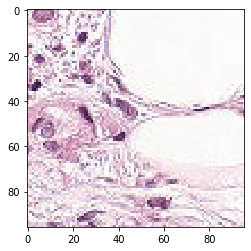

In [9]:
import matplotlib.pyplot as plt

print(final_data_y[1000])
plt.imshow(final_data_x[1000])

0


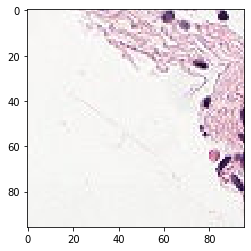

In [10]:
print(final_data_y[0])
plt.imshow(final_data_x[0])

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(final_data_x, final_data_y, test_size=0.1, random_state=123)

In [13]:
Y_train_req = to_categorical(Y_train)
Y_test_req = to_categorical(Y_test)

print(X_train.shape, X_test.shape, Y_train_req.shape, Y_test_req.shape)

(58982, 96, 96, 3) (6554, 96, 96, 3) (58982, 2) (6554, 2)


In [14]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentor = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=True, validation_split=0.1)

# train_batches = augmentor.flow(X_train, Y_train_req, shuffle=True, subset='training')
# val_batches = augmentor.flow(X_train, Y_train_req, subset='validation')

In [15]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, GlobalAveragePooling2D, Input, Activation, concatenate, AveragePooling2D, BatchNormalization, ZeroPadding2D
from tensorflow.keras.models import Model

In [16]:
def dense_layer(inputs, growth_rate):
    
    batch_1 = BatchNormalization(axis=3, epsilon=1.1e-5)(inputs)
    act_1 = Activation('relu')(batch_1)
    conv_1 = Conv2D(growth_rate*4, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(act_1)
    
    batch_2 = BatchNormalization(axis=3, epsilon=1.1e-5)(conv_1)
    act_2 = Activation('relu')(batch_2)
    conv_2 = Conv2D(growth_rate, (3,3), strides=1, padding='same', kernel_initializer='he_normal')(act_2)
    
    output = concatenate([inputs, conv_2], axis=3)
    return output

In [17]:
def transition_layer(inputs, compression_factor):
    
    num_features = inputs.shape[3]
    
    compressed_features = int(num_features * compression_factor)
    
    batch_1 = BatchNormalization(axis=3, epsilon=1.1e-5)(inputs)
    act_1 = Activation('relu')(batch_1)
    conv_1 = Conv2D(compressed_features, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(act_1)
    avg_1 = AveragePooling2D((2,2), strides=2)(conv_1)
    
    return avg_1

In [18]:
def DenseNet121(input_shape, classes):
    
    inputs = Input((input_shape))
    
    zero_pad = ZeroPadding2D((3,3))(inputs)
    
    conv_1 = Conv2D(64, (7,7), strides=2, kernel_initializer='he_normal')(zero_pad)
    conv_1 = BatchNormalization(axis=3, epsilon=1.1e-5)(conv_1)
    conv_1 = Activation('relu')(conv_1)
    conv_1 = ZeroPadding2D((1,1))(conv_1)
    conv_1 = MaxPooling2D((3,3), strides=2)(conv_1)
    
    dense_block_1 = dense_layer(inputs=conv_1, growth_rate=32)
    dense_block_1 = dense_layer(inputs=dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(inputs=dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(inputs=dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(inputs=dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(inputs=dense_block_1, growth_rate=32)
    
    transition_1 = transition_layer(inputs=dense_block_1, compression_factor=0.5)
    
    dense_block_2 = dense_layer(inputs=transition_1, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(inputs=dense_block_2, growth_rate=32)
    
    transition_2 = transition_layer(inputs=dense_block_2, compression_factor=0.5)
    
    dense_block_3 = dense_layer(inputs=transition_2, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(inputs=dense_block_3, growth_rate=32)
    
    transition_3 = transition_layer(inputs=dense_block_3, compression_factor=0.5)

    dense_block_4 = dense_layer(inputs=transition_3, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(inputs=dense_block_4, growth_rate=32)
    
    batch = BatchNormalization(axis=3, epsilon=1.1e-5)(dense_block_4)
    act = Activation('relu')(batch)
    
    avg_pool = GlobalAveragePooling2D()(act)
    
    dense = Dense(classes, activation='softmax')(avg_pool)
    
    model = Model(inputs=inputs, outputs=dense)
    
    return model

In [19]:
model = DenseNet121(input_shape=(96, 96, 3), classes=2)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint(save_best_only=True, monitor='val_accuracy', mode='max', patience=1, filepath='E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Patch Camelyon/patch_camelyon_densenet121.h5')

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# steps = 53083/32

history = model.fit(X_train, Y_train_req, epochs=50, validation_split=0.1, batch_size=64, callbacks=[cp])

Train on 53083 samples, validate on 5899 samples
Epoch 1/50
53083/53083 [==============================] - 435s 8ms/sample - loss: 0.3743 - accuracy: 0.8405 - val_loss: 0.5784 - val_accuracy: 0.8067
Epoch 2/50
53083/53083 [==============================] - 419s 8ms/sample - loss: 0.2970 - accuracy: 0.8773 - val_loss: 0.4818 - val_accuracy: 0.8268
Epoch 3/50
53083/53083 [==============================] - 452s 9ms/sample - loss: 0.2454 - accuracy: 0.9022 - val_loss: 0.3499 - val_accuracy: 0.8518
Epoch 4/50
53083/53083 [==============================] - 459s 9ms/sample - loss: 0.2144 - accuracy: 0.9157 - val_loss: 0.4495 - val_accuracy: 0.8229
Epoch 5/50
53083/53083 [==============================] - 489s 9ms/sample - loss: 0.1920 - accuracy: 0.9253 - val_loss: 0.3541 - val_accuracy: 0.8713
Epoch 6/50
53083/53083 [==============================] - 480s 9ms/sample - loss: 0.1664 - accuracy: 0.9352 - val_loss: 1.1274 - val_accuracy: 0.6862
Epoch 7/50
53083/53083 [===========================

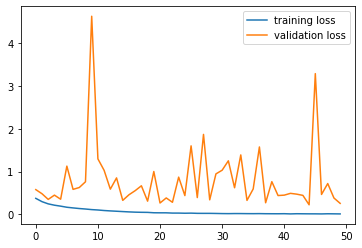

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc='best')
plt.show()

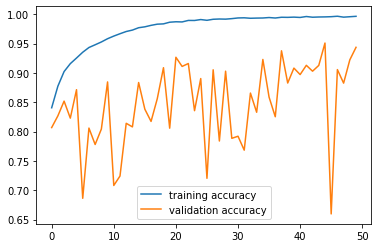

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'], loc='best')
plt.show()

In [26]:
from tensorflow.keras.models import load_model

model_new = load_model('E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Patch Camelyon/patch_camelyon_densenet121.h5')

In [27]:
predictions = []

for i in range(len(X_test)):
    image = X_test[i].reshape((1, 96, 96, 3)).astype('float32')
    pred = model_new.predict(image)
    i = np.argmax(pred)
    predictions.append(i)

In [28]:
predictions

[0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

print(accuracy_score(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
cm

0.9418675617943241


array([[3115,  222],
       [ 159, 3058]], dtype=int64)

In [30]:
import tensorflow as tf

tf.__version__

'2.0.0'